# Missingness Joint Distributions

The question has arisen if we can decide if an individual data point is 0 given its joint distribution of gene x cell. There is a 3rd axis (replicates) that maybe useful too.

In [1]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2018-09-14 
Git hash: 42b50b2bae7773307f49194899ffbeb2475982b9


In [3]:
raw = nbconfig.seurat.get_raw()

clusters = nbconfig.seurat.get_clusters('res.0.6')
clusters = clusters.map(nbconfig.cluster_annot)
clusters = clusters.to_frame()
clusters = clusters.assign(rep=clusters.index.str.extract('(?P<rep>rep\d)', expand=False))

raw_w_meta = raw.T.join(clusters)

In [4]:
# I want to order genes by expression level, but I want to keep the same 
# order across clusters for plotting. Here I order based on total expression 
# across cluster.
genes_idx = raw.sum(axis=1).sort_values().index

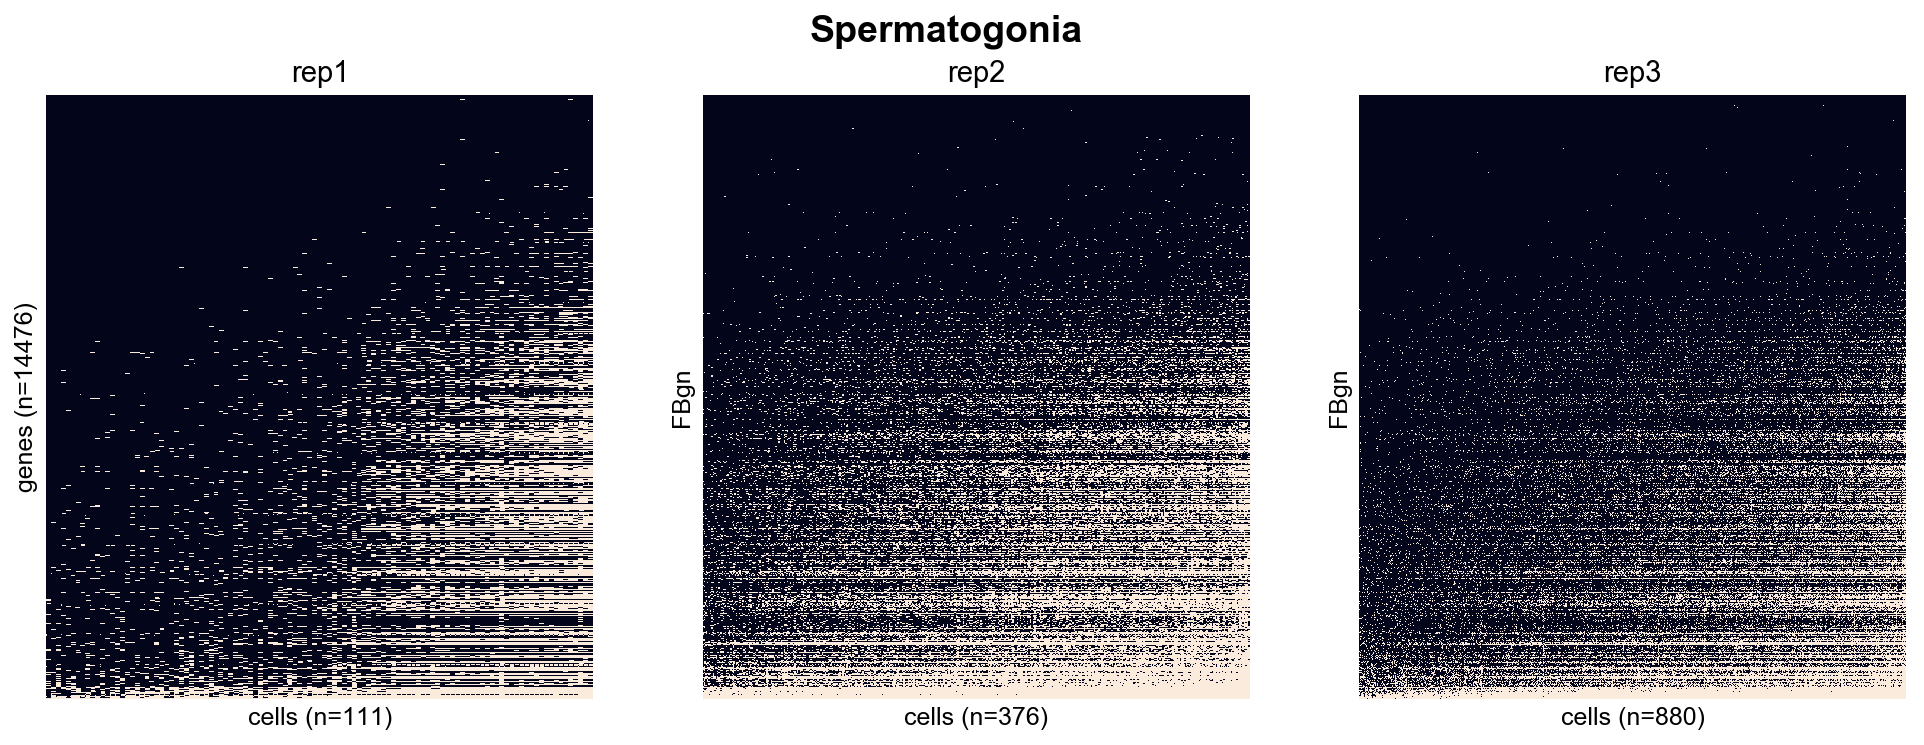

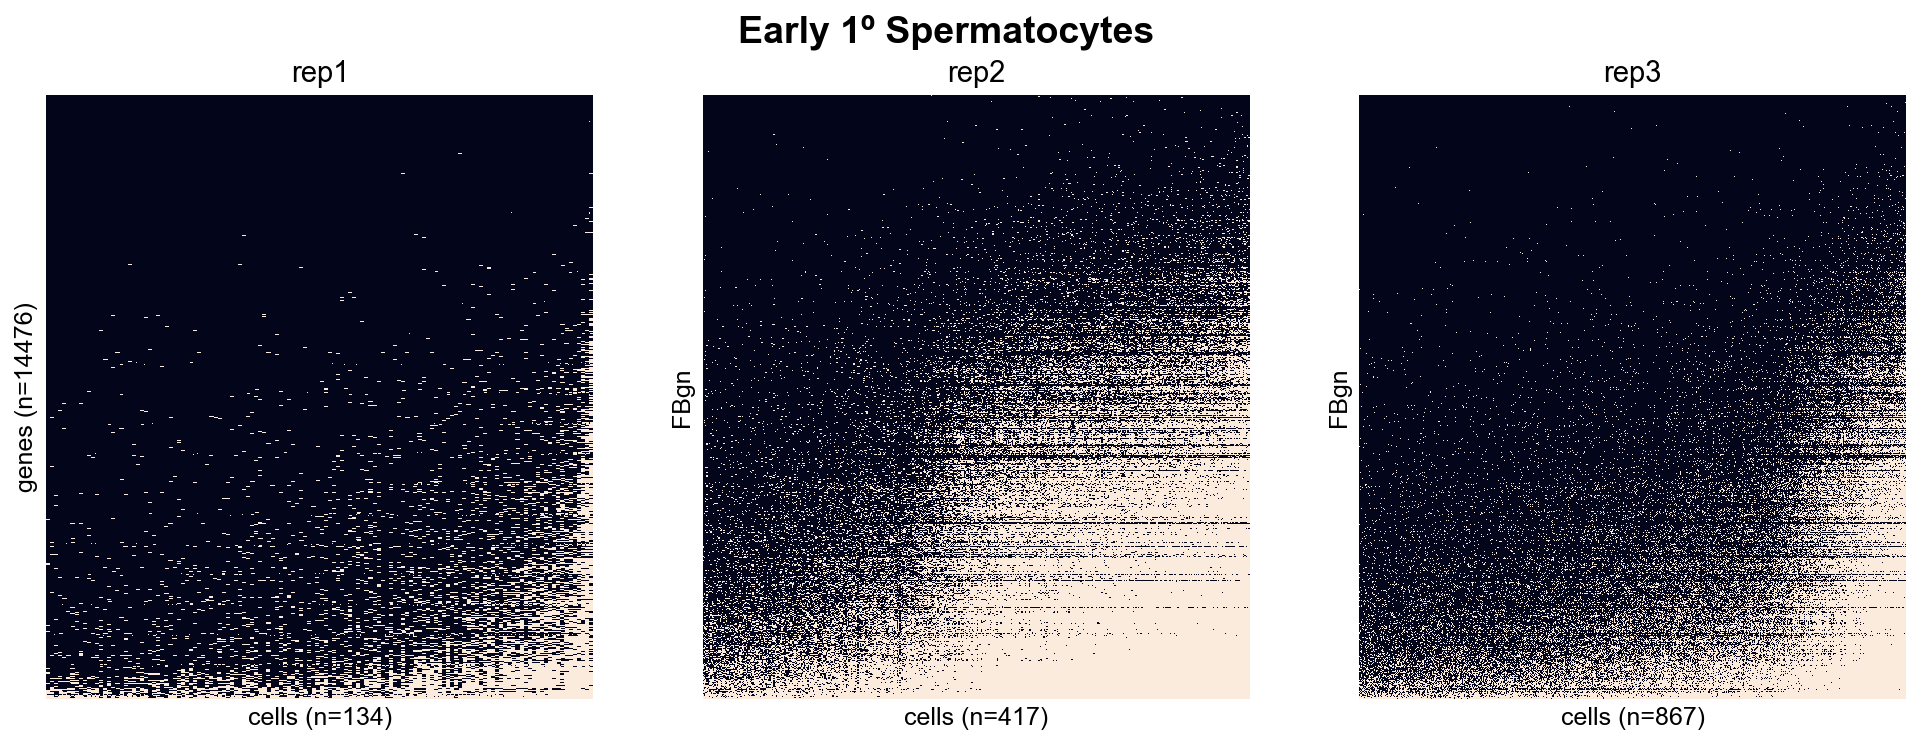

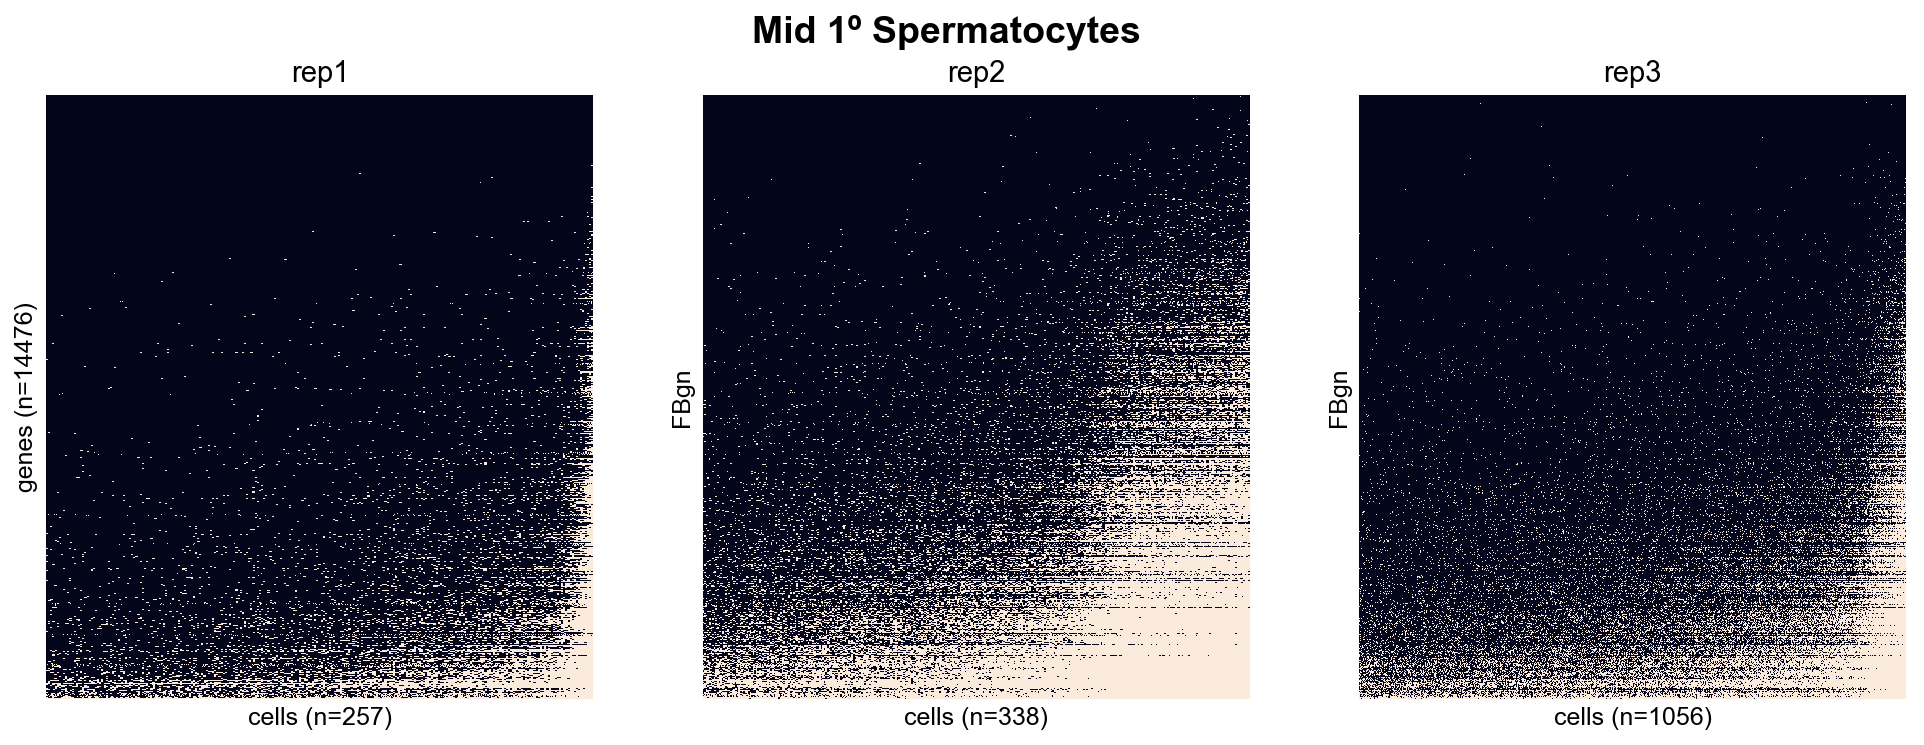

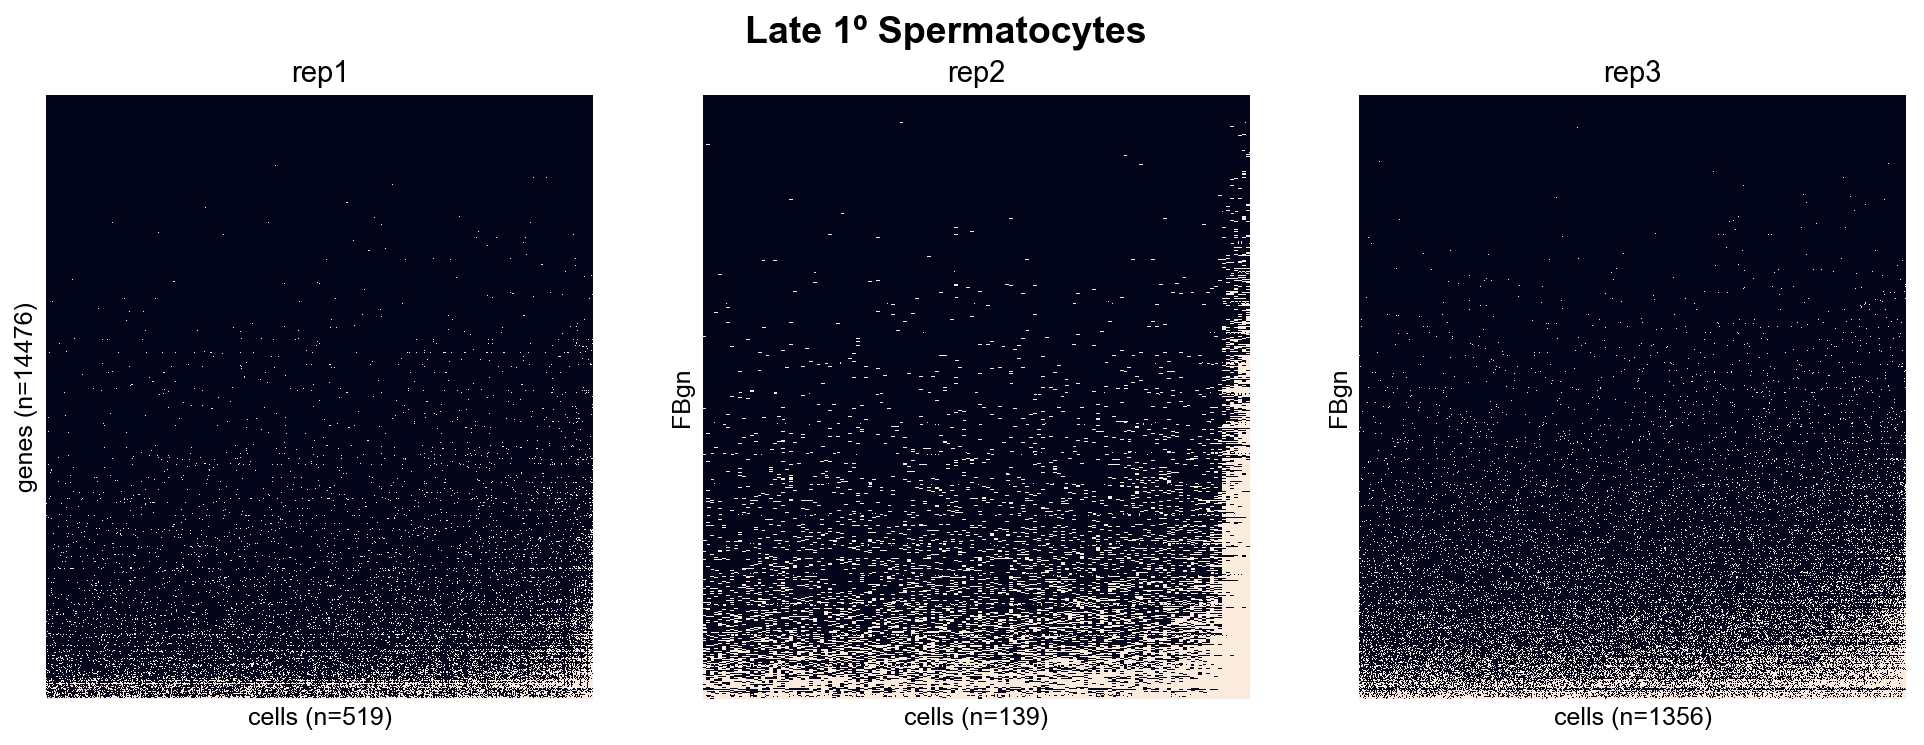

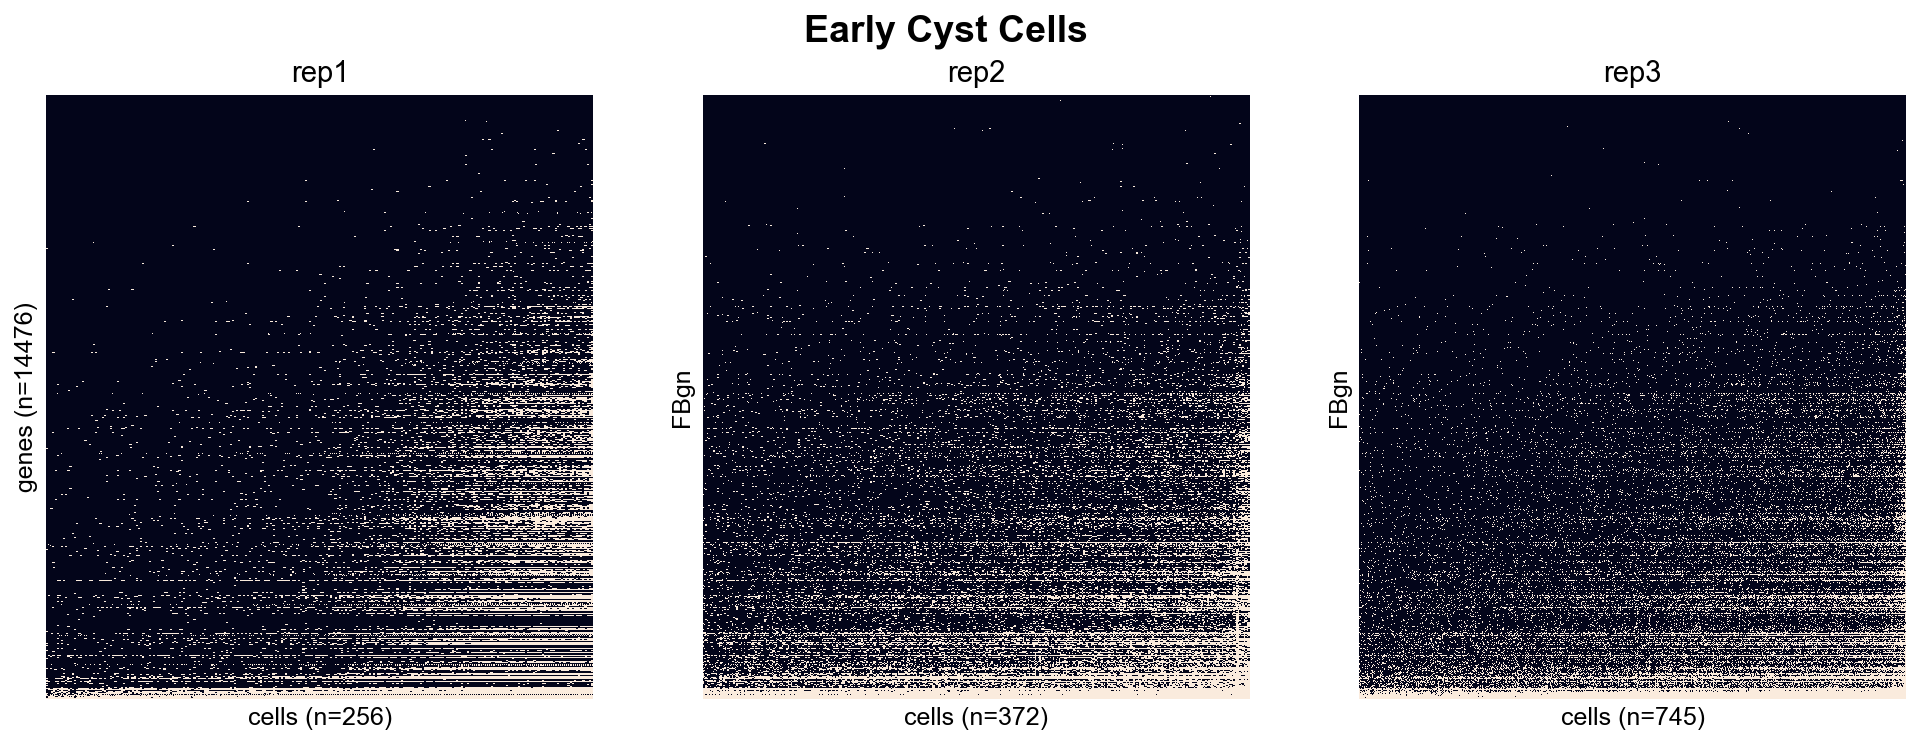

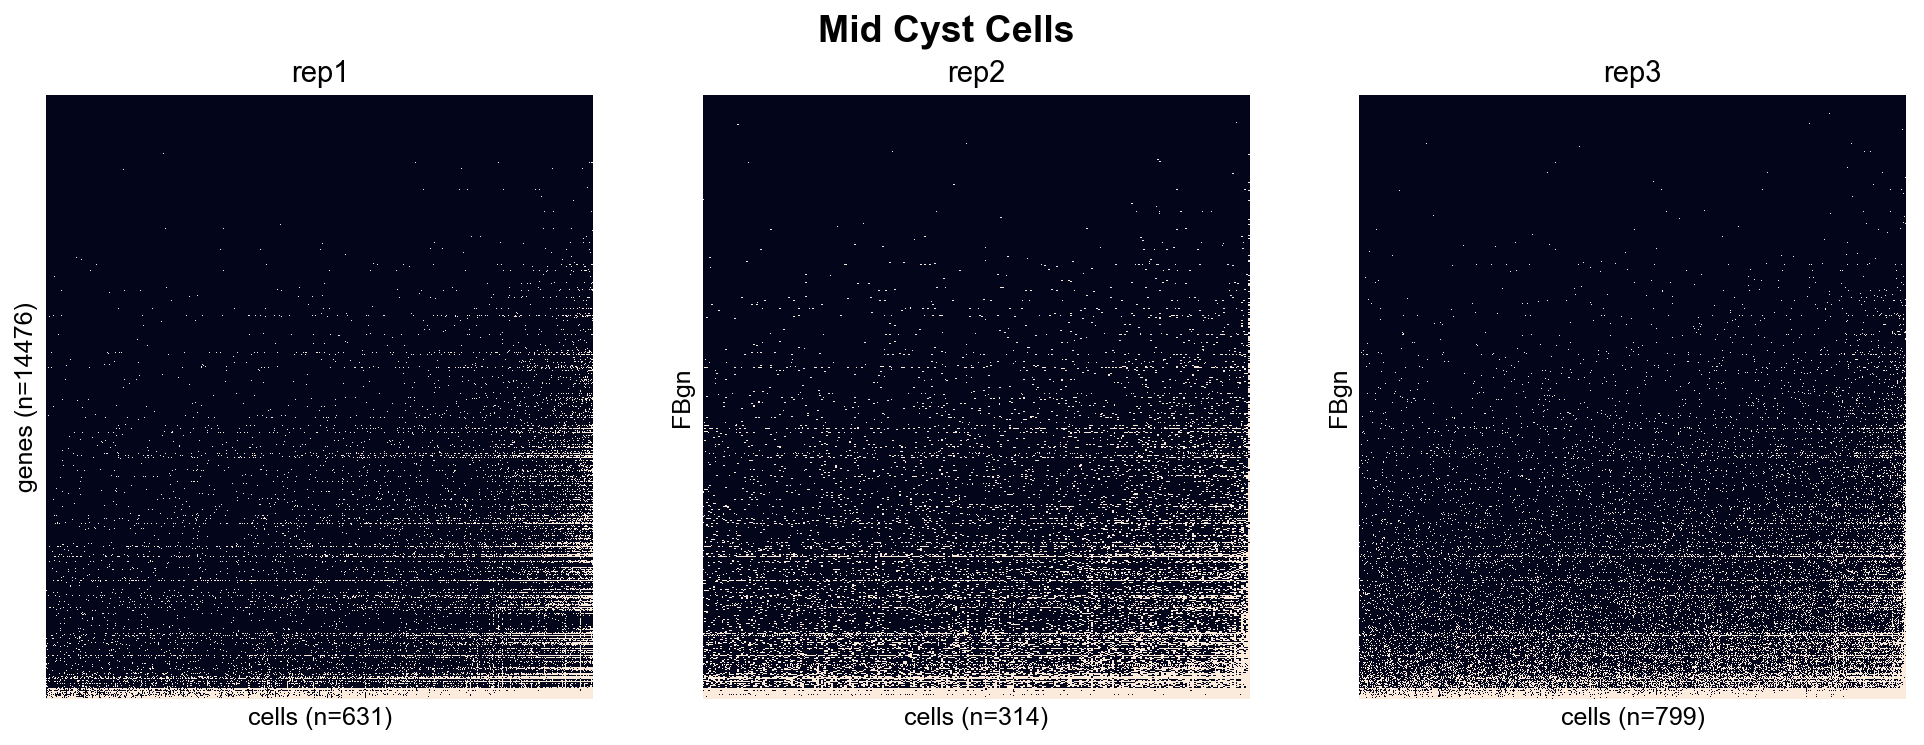

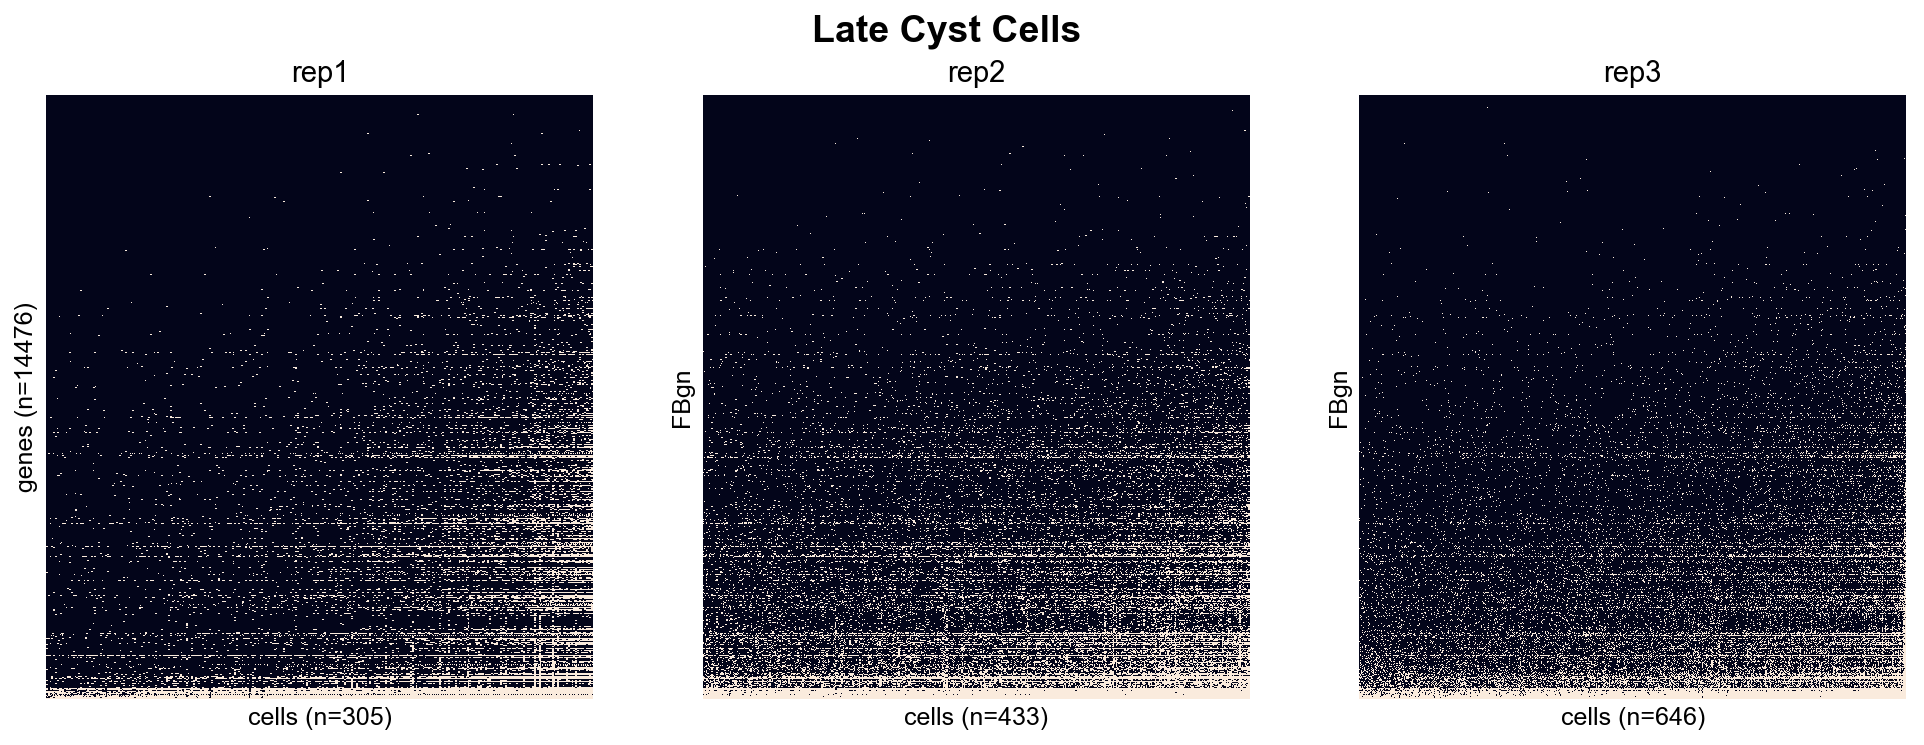

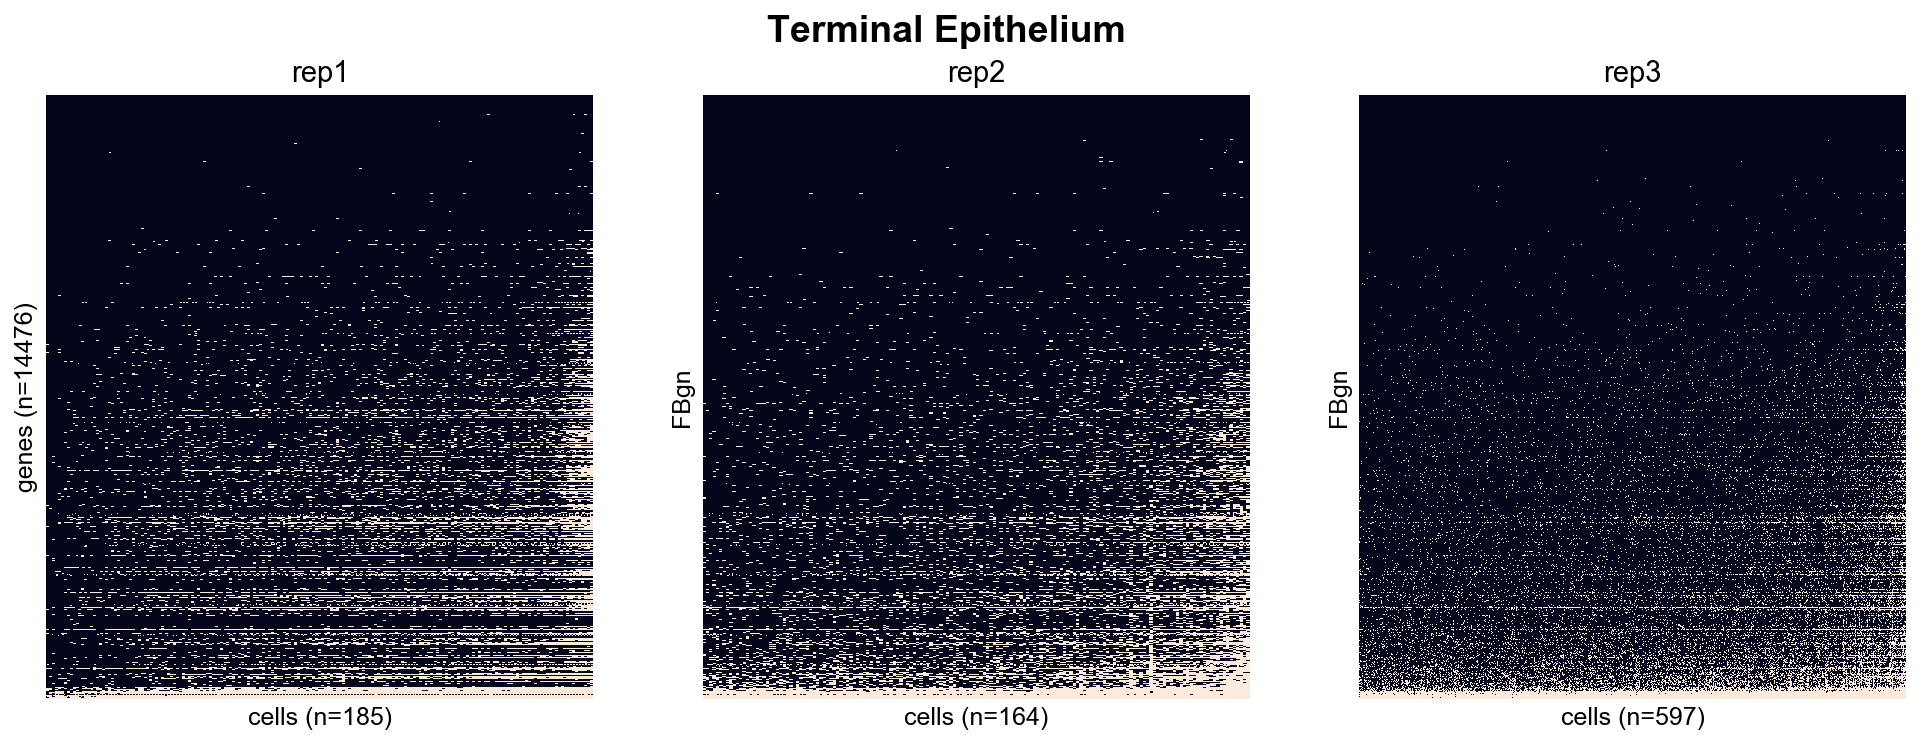

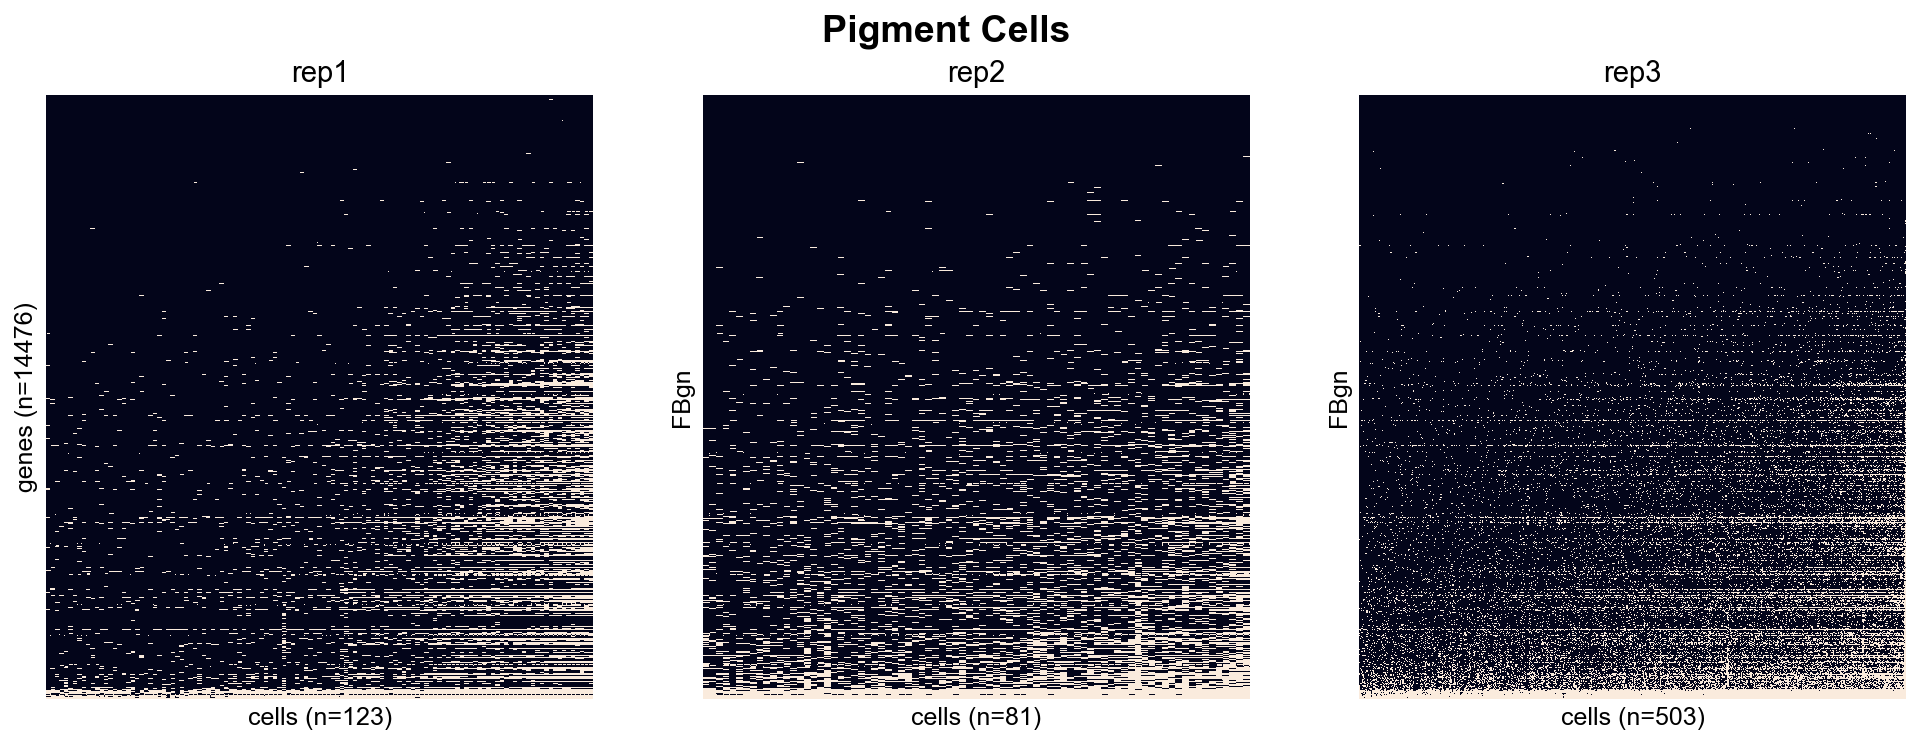

In [21]:
def _plot(cluster):
    # Pull out cluster
    dat = raw_w_meta.query(f'cluster == "{cluster}"').drop('cluster', axis=1)
    
    # plot each rep
    fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(1/3))
    for ax, (g, dd) in zip(axes, dat.groupby('rep')):
        _dat = dd.drop('rep', axis=1).T    # make gene x cell matrix for current rep

        # get the total number of reads for each cell and order by cells read count
        cell_cnts = _dat.sum().sort_values()
        cell_cnts.name = 'Cell Counts'
        cells_idx = cell_cnts.index

        sns.heatmap(_dat.loc[genes_idx, cells_idx] > 0, xticklabels=False, yticklabels=False, ax=ax, cbar=False)
        ax.set_xlabel(f'cells (n={len(cells_idx)})')
        ax.set_title(g)
        
    axes[0].set_ylabel(f'genes (n={len(genes_idx)})')
    fig.suptitle(cluster)

for cluster in nbconfig.sel_cluster_order:
    _plot(cluster)

In [5]:
chrom_genes = {}
for g, dd in raw.join(nbconfig.fbgn2chrom).groupby('chrom'):
    chrom_genes[g] = dd.sum(axis=1).sort_values().index

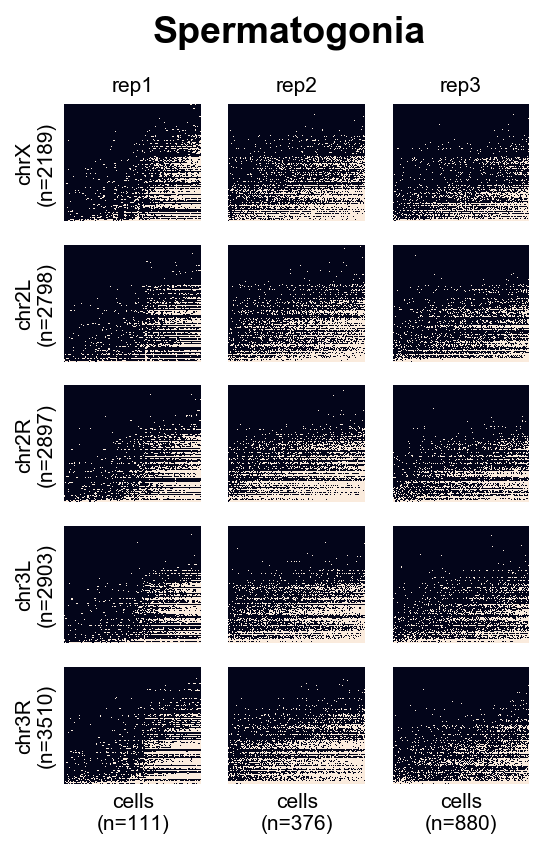

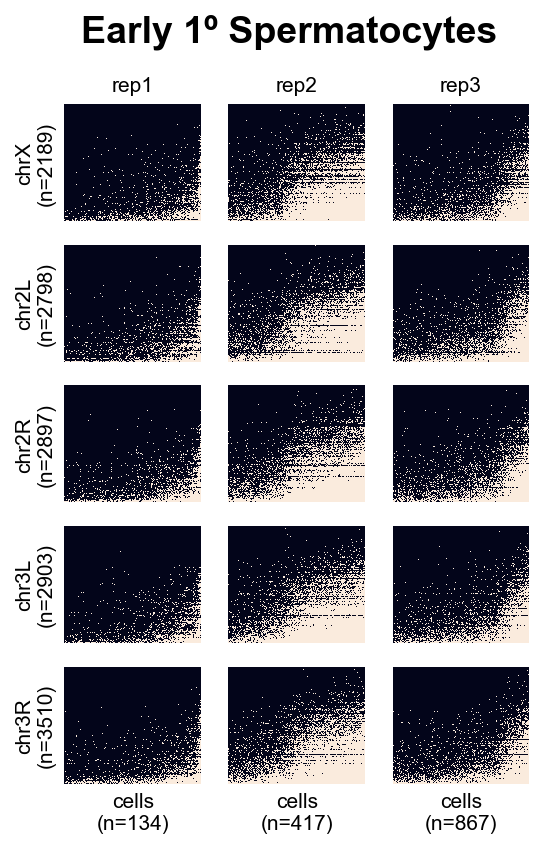

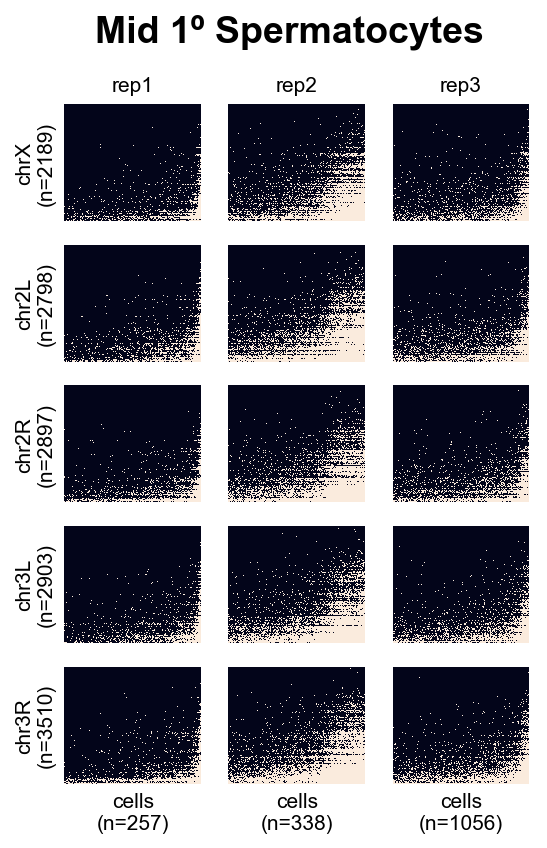

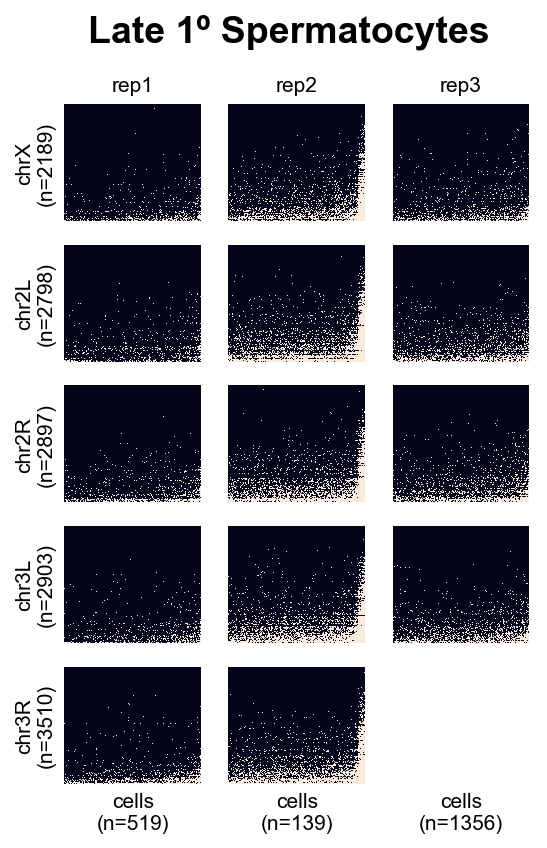

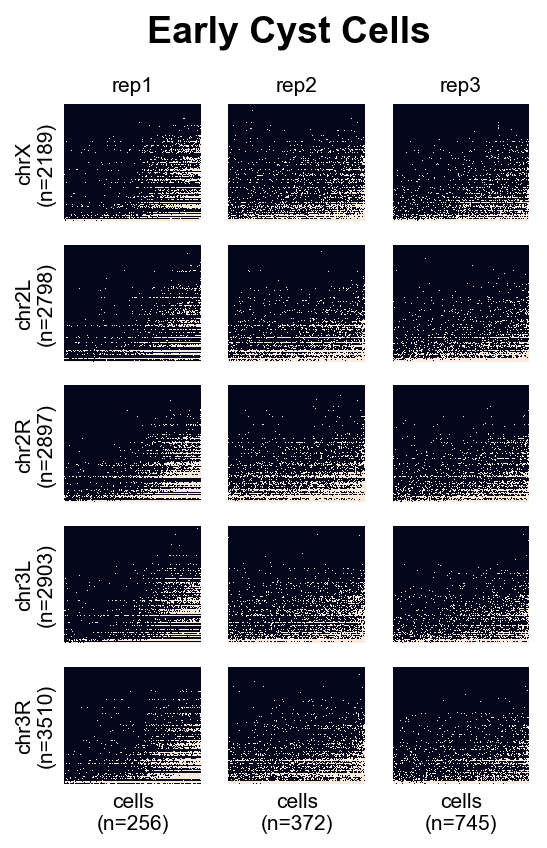

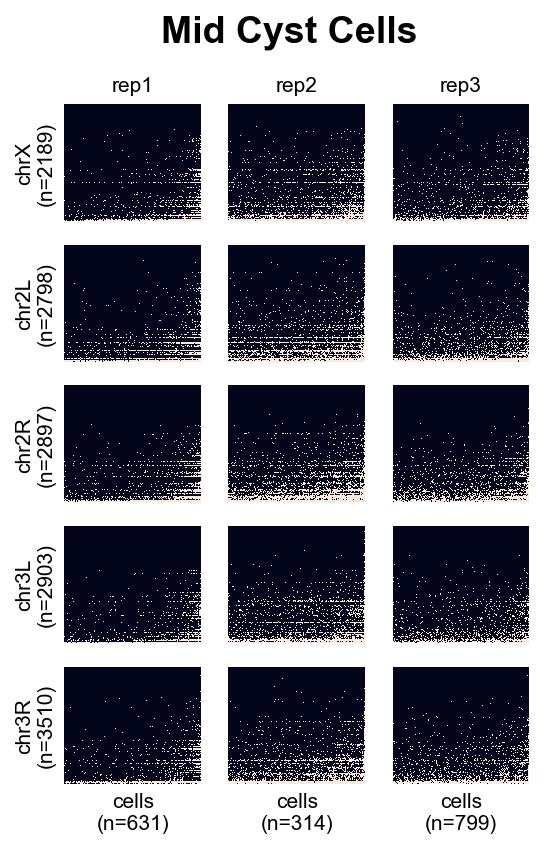

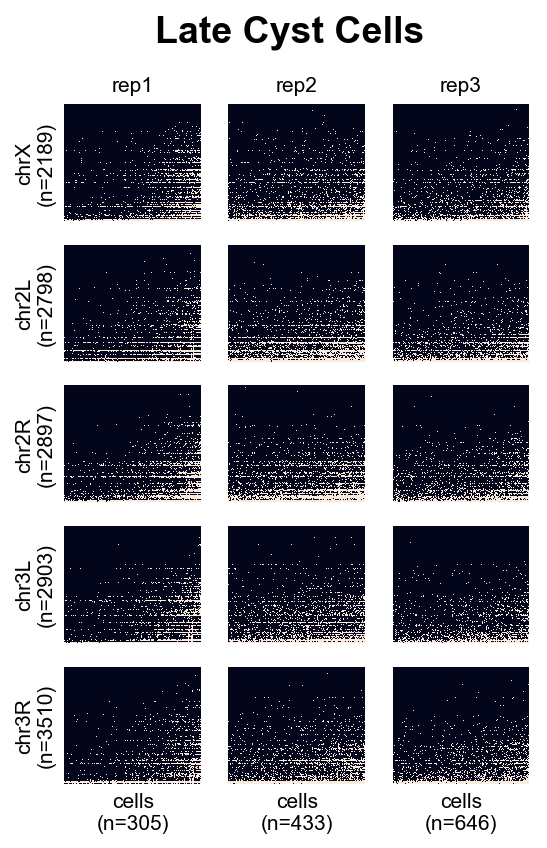

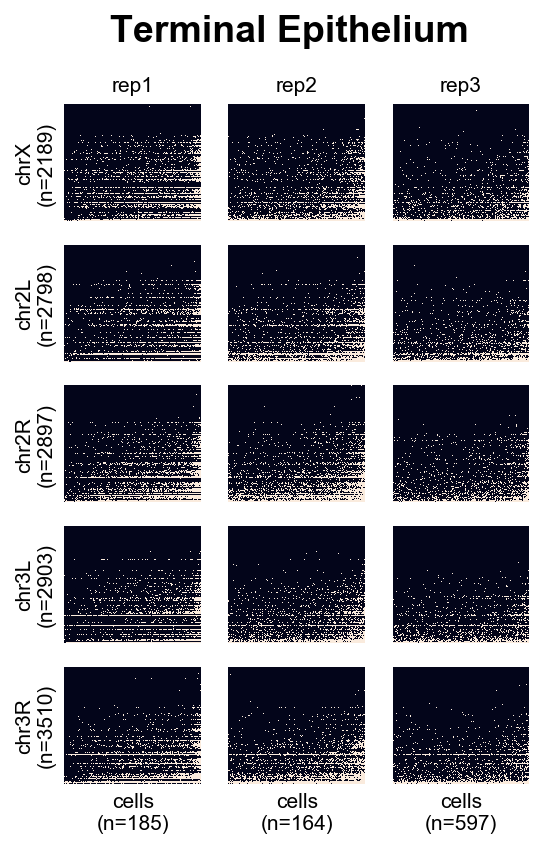

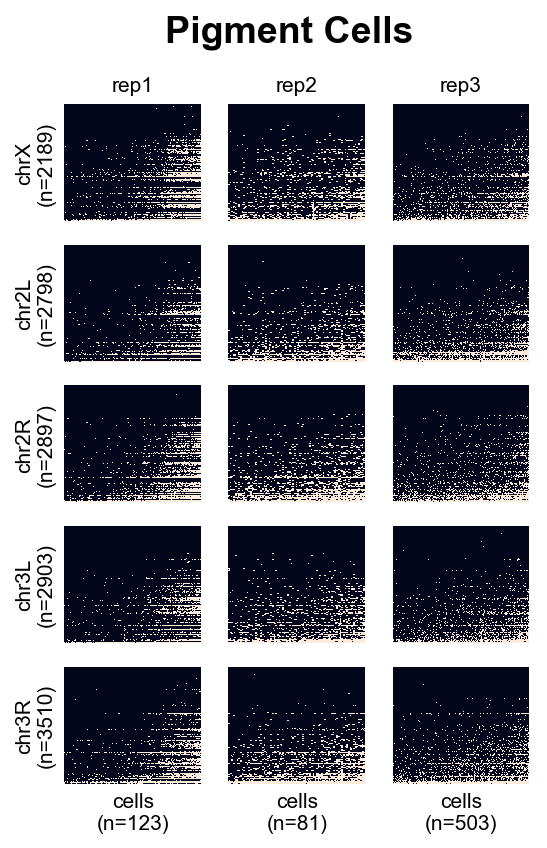

In [16]:
def _plot(cluster):
    # Pull out cluster
    dat = raw_w_meta.query(f'cluster == "{cluster}"').drop('cluster', axis=1)
    
    # set up figure with chroms x reps; only focus on major chroms
    fig, axes = plt.subplots(len(nbconfig.chrom_order[:-2]), 3, figsize=plt.figaspect(1.5))
    
    # for each rep
    for axs, (g, dd) in zip(axes.T, dat.groupby('rep')):
        # make gene x cell matrix for current rep
        _dat = dd.drop('rep', axis=1).T 

        # for each chromosome
        for ax, c in zip(axs, nbconfig.chrom_order[:-2]):
            # make a gene x cell matrix for current chromosome * rep
            _dat2 = _dat.reindex(chrom_genes[c])
            
            # order cells by total read count
            cells_idx = _dat2.sum().sort_values().index

            # plot heatmap where 0 is off and 1 is >0 reads
            sns.heatmap(_dat2.loc[:, cells_idx] > 0, xticklabels=False, yticklabels=False, ax=ax, cbar=False)
            
            # Go ahead and add chrom name and number of genes as ylabel
            ax.set_ylabel(f'{c}\n(n={len(chrom_genes[c])})', fontsize=10)
            
        # Add replciate name as title
        axs[0].set_title(g, fontsize=10)
        
        # Add number of cells as xlabel
        axs[-1].set_xlabel(f'cells\n(n={len(cells_idx)})', fontsize=10)
        
        
    # Cleanup internal axis by removing x and y labels
    for ax in axes[:, 1:].flat:
        ax.set_ylabel('')
    
    for ax in axes[:-1, :].flat:
        ax.set_xlabel('')
    
    # Add cluster as figure title
    fig.suptitle(cluster)

    
for cluster in nbconfig.sel_cluster_order:
    _plot(cluster)